In [284]:
import pandas as pd
import json
import requests
import warnings
from matplotlib import pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
%matplotlib inline
from IPython.display import IFrame
import re
import numpy
from cycler import cycler

font = {'family' : 'helvetica',
        'size'   : 24}

matplotlib.rc('font', **font)

# Cuomo Campaign Contributions from Board of Elections

I read the CSV, then I take the dollar signs out of the 'Amount' column, ...and convert it to float so I can do calculations.

I convert the 'Date' column to Pandas datetime, so I can sort and filter by date.

In [278]:
df = pd.read_csv("Campaign_Contributions.csv")
df = df[['Donor','Address', 'Check No.', 'Amount', 'Date','Recipient','Transaction Code', 'Contribution Code', 'Fiscal Report']]
ftm_df = pd.read_csv("FollowTheMoneyDownload20180705(010706).csv")
#Since Follow the Money is out of date anyway, I'm actually just interested in unique donors over the years.
#This will help me identify Cuomo donors, because so many of them have been his donors for a long time.
ftm_df = ftm_df.drop_duplicates('Original_Name', keep='first')

In [279]:
df['Amount'] = df['Amount'].replace( '[\$,)]','', regex=True ).astype(float)
df['Donor'] = df['Donor'].str.strip()
ftm_df['Original_Name'] = ftm_df['Original_Name'].str.strip() 
new_df = pd.merge(df, ftm_df, left_on='Donor', right_on='Original_Name', how='left', suffixes=['_boe','_ftm'])

## FollowTheMoney has data on individual donors, but they aggregate donations.

So I am going to use their data, combined with Board of Elections donations

In [280]:
new_df['Date'] = pd.to_datetime(new_df['Date_boe'], infer_datetime_format=True)
new_df['Donation_Date']=new_df['Date']
new_df.set_index('Date', inplace=True)
new_df.sort_index(axis=0, inplace=True)
new_df.dropna(subset=['Date_boe'], inplace=True)

In [281]:
new_df = new_df[['Donor', 'Address', 'Check No.', 'Amount_boe', 'Date_boe',
       'Recipient', 'Transaction Code', 'Contribution Code',
       'Fiscal Report',
       'Filing_Jurisdiction', 'Filer',
       'Candidate',
       'Candidate_Entity',
       'Election_Status',
       'Status_of_Candidate',
       'Election_Jurisdiction',
       'Election_Year',
       'Election_Type',
       'Original_Name',
       'Contributor',
       'Type_of_Contributor','Specific_Business', 'General_Industry','Broad_Sector',
       'City','State','Zip', 'In-State',
       'Parent_Org_or_Employer']]

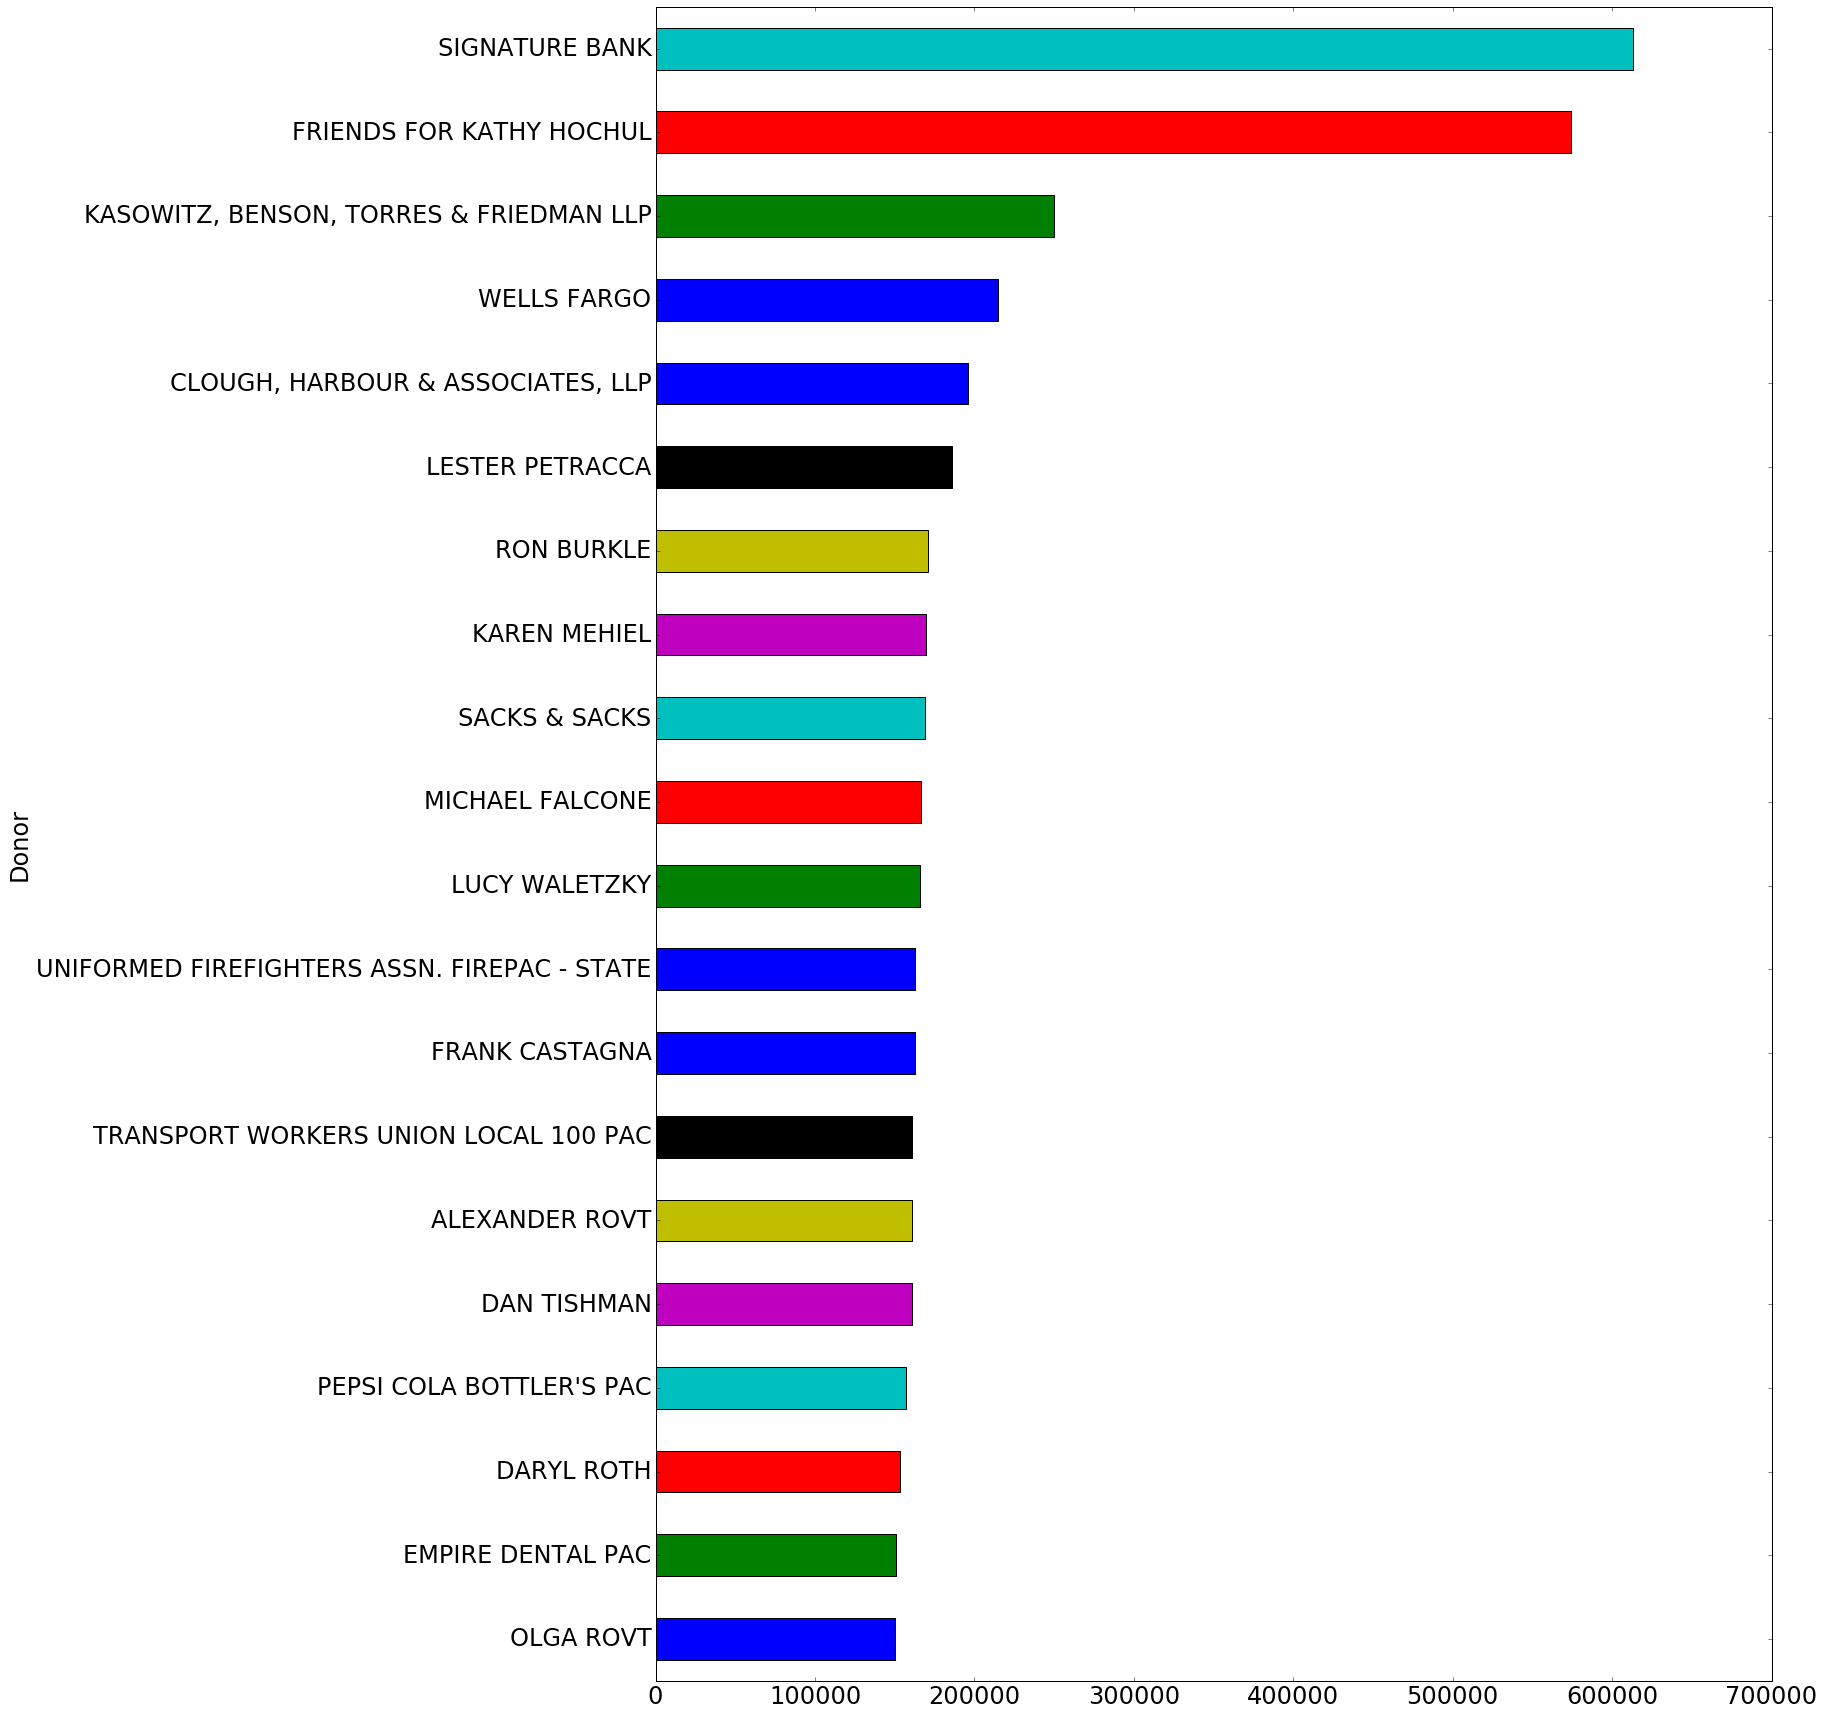

In [282]:
plt.figure(figsize=(20,30))
new_df['2010-01-01':].groupby('Donor').filter(lambda x: x['Amount_boe'].sum()>150000)\
.groupby('Donor')['Amount_boe'].sum().sort_values().plot(kind='barh')

## Notable donors include:
*Signature bank*
- Ivanka Trump is on the board of directors
- Barney Frank is on the board of directors
- Ron Wasserman is an "associate group director", and is a member of AIPAC and chairman of Fuel for Truth, an anti-muslim think tank-funded org

*Kathy Hochul*
- Lieutenant governor of NYS
- "Friends for Kathy Hochul" receives money from LLC's, donates to Cuomo
- Kathy Hochul is heavily invested in the oil industry

*Kasowitz Benson Torres Friedman LLP*
- major RNC donor ($251,900)
- Trump donor
- https://projects.propublica.org/trump-town/organizations/kasowitz-benson-torres-friedman-llp !!!

In [253]:
IFrame('https://littlesis.org/maps/2780-kathy-hochul-s-fossil-fuel-investments/embedded/v2', width=700, height=350, scrolling='no')

## "Governor Glenwood" indeed!

In [254]:
print("Over the years, Glenwood has given", new_df[new_df['Parent_Org_or_Employer'].str.contains("GLENWOOD", na=False)]['Amount_boe'].sum(), "to Cuomo's campaign.")

Over the years, Glenwood has given 889400.0 to Cuomo's campaign.


In [255]:
#EDIT: John and Peter want to look at everything just from 2010 onward.
df_warchest = new_df['2010-01-01':]
df_warchest['Donor'] = df_warchest['Donor'].str.strip()

In [256]:
#These are some entities that I know are Real Estate donors: Fisher Brothers, and Brookfield Properties, NORSTAR.
#May 18, 2017, Cuomo announces renewal of 421a. One day later, May 19, 2017, he receives 159,000

#Fisher Brothers
df_warchest.loc[df_warchest['Donor'].str.contains("FISHER BROTHERS", na=False), 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("FISHER BROTHERS", na=False), 'Parent_Org_or_Employer']='Fisher Brothers'
df_warchest.loc[df_warchest['Address']=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Address']=='FL 42 299 PARK AVE NEW YORK, NY, 10171', 'Parent_Org_or_Employer']='Fisher Brothers'

#Brookfield
df_warchest.loc[df_warchest['Donor'].str.contains("BOP", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("BOP", na=False), 'Parent_Org_or_Employer']='Brookfield'

#Longpoint Capital
df_warchest.loc[df_warchest['Donor'].str.contains("CLOUGH, HARBOUR", na=False), 'Parent_Org_or_Employer']='Longpoint Capital'
df_warchest.loc[df_warchest['Donor'].str.contains("CLOUGH, HARBOUR", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

#NORSTAR
df_warchest.loc[((df_warchest['General_Industry'] == 'Uncoded') & (df_warchest['Donor'].str.contains("NORSTAR"))), 'General_Industry']='Real Estate'

#RXR, REXSCOTT
df_warchest.loc[df_warchest['Donor'].str.contains("REXSCOTT", na=False), 'Parent_Org_or_Employer']='RXR Realty'
df_warchest.loc[((df_warchest['General_Industry'] == 'Uncoded') & (df_warchest['Donor'].str.contains("REXSCOTT"))), 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor'].str.contains("RXR", na=False), 'Parent_Org_or_Employer']='RXR Realty'
df_warchest.loc[df_warchest['Address']=='625 RXR PLZ UNIONDALE, NY, 11556', 'Parent_Org_or_Employer']='RXR Realty'
df_warchest.loc[df_warchest['Address']=='625 RXR PLZ UNIONDALE, NY, 11556', 'General_Industry']='Real Estate'

#STV
df_warchest.loc[df_warchest['Donor'].str.contains(r"\bSTV\b", na=False), 'Parent_Org_or_Employer']='STV Incorporated'
df_warchest.loc[df_warchest['Donor']=="STV", 'General_Industry']='Construction Services'
df_warchest.loc[df_warchest['Donor']=="STV", 'Parent_Org_or_Employer']='STV Incorporated'

df_warchest.loc[df_warchest['Address']=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'Parent_Org_or_Employer'] = 'STV Incorporated'
df_warchest.loc[df_warchest['Address']=='205 W WELSH DR DOUGLASSVILLE, PA, 19518', 'General_Industry']='Construction Services'
df_warchest.loc[df_warchest['Donor']=='MILO RIVERSO', 'Parent_Org_or_Employer'] = 'STV Incorporated'
df_warchest.loc[df_warchest['Donor']=='MILO RIVERSO', 'General_Industry']='Construction Services'
df_warchest.loc[df_warchest['Donor']=='DOMINICK SERVEDIO', 'Parent_Org_or_Employer'] = 'STV Incorporated'
df_warchest.loc[df_warchest['Donor']=='DOMINICK SERVEDIO', 'General_Industry']='Construction Services'
df_warchest.loc[df_warchest['Donor']=='WILLIAM MATTS', 'Parent_Org_or_Employer'] = 'STV Incorporated'
df_warchest.loc[df_warchest['Donor']=='WILLIAM MATTS', 'General_Industry']='Construction Services'

#Project Compassion
df_warchest.loc[df_warchest['Address']=='STE 146 11315 RANCHO BERNARDO RD SAN DIEGO, CA, 92127', 'General_Industry']='Nonprofit Institutions'
df_warchest.loc[df_warchest['Address']=='STE 146 11315 RANCHO BERNARDO RD SAN DIEGO, CA, 92127', 'Parent_Org_or_Employer']='Project Compassion'
                
#Nixon Peabody, LLP
df_warchest.loc[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'Parent_Org_or_Employer']='Nixon Peabody LLP'
df_warchest.loc[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604', 'General_Industry']='Lawyers & Lobbyists'

#List of subsidiaries of Cablevision, from: https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
cablevision_list = ["1015 TIFFANY STREET", "1047 E 46TH STREET", "111 NEW SOUTH ROAD", "1111 STEWART",
"1144 ROUTE 109 CORP.", "151 S. FULTON STREET", "2234 FULTON STREET", "389 ADAMS STREET", "4CONNECTIONS",
"A-R CABLE SERVICES - NY", "BBHI HOLDINGS", "CCG HOLDINGS", "Clearview Cinemas", "CORAM ROUTE 112",
"CSC ACQUISITION - MA", "CSC ACQUISITION - NY", "CSC ACQUISITION", "CSC GATEWAY", "CSC INVESTMENTS",
"CSC MVDDS", "CSC NASSAU II", "CSC OPTIMUM HOLDINGS", "CSC T HOLDINGS I", "CSC T HOLDINGS II",
"CSC T HOLDINGS III", "CSC T HOLDINGS IV", "CSC TECHNOLOGY", "CSC TKR",
"CSC TRANSPORT II", "CSC TRANSPORT III", "CSC TRANSPORT", "CSC VT", "DTV NORWICH",
"Clearband", "FROWEIN ROAD", "LIGHTPATH VOIP", "MSG VARSITY NETWORK", "MSG Varsity Network",
"MSGVN", "N12N", "NEWS 12 COMPANY", "News 12", "NEWSDAY", "NMG HOLDINGS", "NY OV LLC", "PETRA CABLEVISION CORP.",
"PRINCETON VIDEO IMAGE ISRAEL", "PVI HOLDINGS", "PVI PHILIPPINES", "PVI VIRTUAL MEDIA SERVICES",
"RAINBOW MVDDS COMPANY", "RASCO HOLDINGS", "RMVDDS", "OMGFAST!", "SAMSON CABLEVISION CORP.",
"SUFFOLK CABLE", "TELERAMA", "THE NEW YORK INTERCONNECT", "TRISTATE DIGITAL GROUP", "WIFI CT-NJ", "WIFI NY"]
#https://www.sec.gov/Archives/edgar/data/784681/000162828016011667/cvc-12312015xex21.htm
for shell in cablevision_list:    
    df_warchest.loc[df_warchest['Donor'].str.contains(shell, re.IGNORECASE, na=False), 'Parent_Org_or_Employer']='Cablevision Systems'
    df_warchest.loc[df_warchest['Donor'].str.contains(shell, re.IGNORECASE, na=False), 'General_Industry']='Cable TV'
    
df_warchest.loc[df_warchest['Donor'] == 'NY OV LLC', 'Parent_Org_or_Employer']='Cablevision Systems'
df_warchest.loc[df_warchest['Donor'] == 'NY OV LLC', 'General_Industry']='Cable TV'


#Anthony Bacchi, founder of Teli Stat, recipient of 5 million NY state grant, also CEO of Restorative Continuum, LLC
df_warchest.loc[df_warchest['Donor']=='RESTORATIVE CONTINUUM LLC', 'General_Industry']='Health Services'
df_warchest.loc[df_warchest['Donor']=='RESTORATIVE CONTINUUM LLC', 'Parent_Org_or_Employer']='Teli Stat'

df_warchest.loc[df_warchest['Address']== '30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354', 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Address']== '30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354', 'Parent_Org_or_Employer']='Triangle Equities'


#Macquesten, their president, and their principal
#Also '3300 KOSSUTH PARTNERS LLC' is a subsidiary: https://opengovus.com/new-york-state-corporation/4737731
df_warchest.loc[df_warchest['Address']== 'STE 100 438 FIFTH AVE PELHAM, NY, 10803', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Address']== 'STE 100 438 FIFTH AVE PELHAM, NY, 10803', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Address']=='STE 100, 438 FIFTH AVE PELHAM, NY, 10803', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Address']=='STE 100, 438 FIFTH AVE PELHAM, NY, 10803', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Address']== '438 FIFTH AVE PELHAM, NY, 10803', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Address']== '438 FIFTH AVE PELHAM, NY, 10803', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Donor']== 'RELLA FOGLIANO', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Donor']== 'RELLA FOGLIANO', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Donor']== 'JOSEPH BREDA', 'General_Industry']='General Contractors'
df_warchest.loc[df_warchest['Donor']== 'JOSEPH BREDA', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Donor']=='PALMER COURT ASSOCIATES, LLC', 'Parent_Org_or_Employer']='Macquesten Development'
df_warchest.loc[df_warchest['Donor']=='PALMER COURT ASSOCIATES, LLC', 'General_Industry']='General Contractors'
                
#This address corresponds to Carson Equities, LLC:
#http://carson-equities.com/contact/
df_warchest.loc[df_warchest['Address']== '4111 ANDOVER RD BLOOMFIELD TOWN, MI, 48302', 'General_Industry']= 'Real Estate'

#STGG Realty LLC/Aro Holdings LLC
df_warchest.loc[df_warchest['Donor']=='STGG REALTY LLC', 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor']=='STGG REALTY LLC', 'Parent_Org_or_Employer']='Aro Holdings LLC'

#NYSAFAH PAC
df_warchest.loc[df_warchest['Address']=='FRNT 3 242 W 36TH ST NEW YORK, NY, 10018', 'General_Industry']= 'Real Estate'
df_warchest.loc[df_warchest['Address']=='FRNT 3 242 W 36TH ST NEW YORK, NY, 10018', 'Parent_Org_or_Employer']='NYSAFAH'
#SFA
df_warchest.loc[df_warchest['Address']=='RM 2800 675 3RD AVE NEW YORK, NY, 10017', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
df_warchest.loc[df_warchest['Address']=='RM 2800 675 3RD AVE NEW YORK, NY, 10017', 'Parent_Org_or_Employer']='SFA'

#State Street Title Agency
df_warchest.loc[df_warchest['Address']=='2R 2413 3RD AVE BRONX, NY, 10451', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
df_warchest.loc[df_warchest['Address']=='2R 2413 3RD AVE BRONX, NY, 10451', 'Parent_Org_or_Employer']='State Street Title Agency'

#BUILDING TRADES EMPLOYERS ASSOCIATION OF NEW YORK CITY
df_warchest.loc[df_warchest['Address']=='RM 1106 1430 BROADWAY NEW YORK, NY, 10018', 'Parent_Org_or_Employer']='BUILDING TRADES EMPLOYERS ASSOCIATION OF NEW YORK CITY'
df_warchest.loc[df_warchest['Address']=='RM 1106 1430 BROADWAY NEW YORK, NY, 10018', 'General_Industry']='General Contractors'

#US Immigration Fund and Nicholas Mastroianni
#Subject of letter to Kushner Companies: https://advance-lexis-com.ezproxy.cul.columbia.edu/document/?pdmfid=1516831&crid=6477e7ad-e14b-46dc-90ee-04cff06df089&pddocfullpath=%2Fshared%2Fdocument%2Fnews%2Furn%3AcontentItem%3A5NP2-5X81-DYVR-P1JM-00000-00&pddocid=urn%3AcontentItem%3A5NP2-5X81-DYVR-P1JM-00000-00&pdcontentcomponentid=247474&pdteaserkey=sr0&pditab=allpods&ecomp=cy3k&earg=sr0&prid=90da6d5c-476c-447a-b7a3-5c6610ef4ac9
df_warchest.loc[df_warchest['Address']=='80 STATE ST ALBANY, NY, 12207', 'Parent_Org_or_Employer']='US Immigration Fund'
df_warchest.loc[df_warchest['Address']=='80 STATE ST ALBANY, NY, 12207', 'General_Industry']='Securities & Investment'

## I fold in the shell LLC's I found in DOB and attribute them to their parent corporations

In [325]:
#Walison Corporation, Sabah Rajput
df_warchest.loc[df_warchest['Donor']=='1060 UNIVERSITY AVE LLC','General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor']=='1060 UNIVERSITY AVE LLC','Parent_Org_or_Employer']='Walison Corporation'
df_warchest.loc[df_warchest['Donor']=='2238 CRESTON AVENUE LLC','General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor']=='2238 CRESTON AVENUE LLC','Parent_Org_or_Employer']='Walison Corporation'

#Glenwood has contributed lots to Cuomo under "Glenwood", but they also use shell LLC's to donate lots more!
glenwood =['TRIBECA NORTH END LLC', 'BARCLAY STREET REALTY LLC',
           'LIBERTY STREET REALTY LLC', 'EAST 103RD STREET REALTY LLC',
           '92ND REALTY LLC', 'ARWIN 74TH STREET LLC', 'EAST 72ND REALTY LLC', 'EAST 81ST REALTY, LLC'
          'EAST 85TH REALTY LLC', 'EAST 77TH REALTY LLC']
for glen in glenwood:
    df_warchest.loc[df_warchest['Donor']==glen, 'Parent_Org_or_Employer']='GLENWOOD MANAGEMENT'
    df_warchest.loc[df_warchest['Donor']==glen, 'General_Industry']='Real Estate'

   
df_warchest.loc[df_warchest['Address']=='1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040' , 'Parent_Org_or_Employer']='GLENWOOD MANAGEMENT'
df_warchest.loc[df_warchest['Address']=='1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040' , 'General_Industry']='Real Estate'

resnick = ['315 HUDSON LLC', '250 HUDSON STREET LLC', 'RESNICK SEAPORT LLC',
     '133 E 58TH STREET LLC', '161 WILLIAM STREET LLC',
     'AB 40TH STREET LLC', 'RESNICK 255 GREENWICH LLC', 'RB 52 CO. LLC']

for res in resnick:
    df_warchest.loc[df_warchest['Donor']==res, 'Parent_Org_or_Employer']='Jonathan Resnick'
    df_warchest.loc[df_warchest['Donor']==res, 'General_Industry']='Real Estate'

#Durst
esposito = ['DOLP 733 PROPERTIES LLC', 'DOLP 1155 PROPERTIES LLC', 'DOLP 1133 PROPERTIES LLC',
            'DOLP 675 PROPERTIES LLC', 'DOLP 205 PROPERTIES LLC', 'DOLP 114 PROPERTIES LLC',
            'THE HELENA ASSOCIATES LLC']
for esp in esposito:
    df_warchest.loc[df_warchest['Donor']==esp, 'Parent_Org_or_Employer']='DURST ORGANIZATION'
    df_warchest.loc[df_warchest['Donor']==esp, 'General_Industry']='Real Estate'

#Steiner Equities Group
steiner = ['25 WA ASSOCIATES LLC', '181 AVENUE A, LLC', '25WA ASSOCIATES, LLC']
for stein in steiner:
    df_warchest.loc[df_warchest['Donor']==stein, 'Parent_Org_or_Employer']='Steiner Equities Group'
    df_warchest.loc[df_warchest['Donor']==stein, 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Address']=='75 EISENHOWER PARKWAY ROSELAND, NJ, 07068', 'Parent_Org_or_Employer']='Steiner Equities Group'
df_warchest.loc[df_warchest['Address']=='75 EISENHOWER PARKWAY ROSELAND, NJ, 07068', 'General_Industry']='Real Estate'

#Roxann Management Corp
roxann = ['203 WEST 90TH STREET RETAIL LLC', '1628 SECOND AVENUE RETAIL LLC',
          '170 WEST 75TH STREET RETAIL LLC',
           '215 WEST 90TH STREET RETAIL LLC']
for rox in roxann:
    df_warchest.loc[df_warchest['Donor']==stein, 'Parent_Org_or_Employer']='Roxann Management Corp'
    df_warchest.loc[df_warchest['Donor']==stein, 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor'] == 'CURTIS KATZ', 'Parent_Org_or_Employer']='Roxann Management Corp'
df_warchest.loc[df_warchest['Donor'] == 'CURTIS KATZ','General_Industry']='Real Estate'    

#Orbach Group
orbach = ['BEACON 109 203-205, LLC', 'LIGHTHOUSE 49 LLC']
for orb in orbach:
    df_warchest.loc[df_warchest['Donor']==orb, 'Parent_Org_or_Employer']='Orbach Group'
    df_warchest.loc[df_warchest['Donor']==orb, 'General_Industry']='Real Estate'
df_warchest.loc[df_warchest['Donor']=='PO BOX 1524 ENGLEWOOD CLIFF, NJ, 07632', 'Parent_Org_or_Employer']='Orbach Group'
df_warchest.loc[df_warchest['Donor']=='PO BOX 1524 ENGLEWOOD CLIFF, NJ, 07632', 'General_Industry']='Real Estate'

#Atlantic Development Group
atlantic = ['MARC ALTHEIM', 'PETER FINE', 'KNICKERBOCKER MANAGEMENT LLC','KNICKERBOCKER MANAGEMENT, LLC']
for atl in atlantic:
    df_warchest.loc[df_warchest['Donor']==atl, 'Parent_Org_or_Employer']='Atlantic Development Group'
    df_warchest.loc[df_warchest['Donor']==atl, 'General_Industry']='Real Estate'
    
#MADDD Equities
maddd = ["JACKSON BUILDERS, LLC","ST. ANN'S CDE OWNER LLC", 'MADDD EQUITIES LLC']
for mad in maddd:
    df_warchest.loc[df_warchest['Donor']==mad, 'Parent_Org_or_Employer']='MADDD Equities'
    df_warchest.loc[df_warchest['Donor']==mad, 'General_Industry']='Real Estate'

    
#Clover, Michael Joseph, Howard Zemsky
clover = ["10 SULTAN'S COURT BUFFALO, NY, 14221","10 SULTAN'S COURT WILLIAMSVILLE, NY, 14221",
         "10 SULTANS CT WILLIAMSVILLE, NY, 14221","348 HARRIS HILL ROAD WILLIAMSVILLE, NY, 14221"]

for clov in clover:
    df_warchest.loc[df_warchest['Address']==clov, 'Parent_Org_or_Employer']='Clover Construction'
    df_warchest.loc[df_warchest['Address']==clov, 'General_Industry']='Real Estate'

# FOUR M HOLDINGS
df_warchest.loc[df_warchest['Donor'].str.contains("MEHIEL", na=False), 'Parent_Org_or_Employer']='Four M Holdings'
df_warchest.loc[df_warchest['Donor'].str.contains("MEHIEL", na=False), 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'
df_warchest.loc[df_warchest['Donor'] == 'FOUR M CAPITAL, LLC', 'Parent_Org_or_Employer']='Four M Holdings'
df_warchest.loc[df_warchest['Donor']=='FOUR M FRANCHISING, LLC', 'General_Industry']='Miscellaneous Finance, Insurance & Real Estate'

In [326]:
rec_df=df_warchest['2017-01-01':]
rec_df[rec_df['General_Industry'] == 'Uncoded'].groupby('Address')['Amount_boe'].sum().sort_values(ascending=False)
#rec_df[(rec_df['Date_boe']=='05/30/2017')&(rec_df['General_Industry'] == 'Uncoded')].sort_values(by='Amount_boe', ascending=False)
df_warchest[df_warchest['Donor'].str.contains("JORGE", na=False)]
df_warchest[df_warchest['Address'].str.contains("5 DORCHESTER DRIVE", na=False)]
#rec_df[rec_df['Date_boe']=='01/09/2017'].sort_values(by='Amount_boe', ascending=False)
df_warchest[df_warchest['Parent_Org_or_Employer']=='Four M Holdings']['Amount_boe'].sum()

275863.0

## Project Compassion NY LLC
- gave a one-time contribution of $50,000 on 12/13/2017
- Is based in California?? No idea what the connection is and probably not something we should pursue. Small fish!

## Restorative Continuum LLC
- CEO is Anthony Bachi, also the founder of Telistat, which is received a 5 million grant in 2016, and in August 2017 a Long Island facility got a 1.5 million grant to implement a Telistat Restorative Care Unit.
- https://www.prnewswire.com/news-releases/telistat-introduces-innovative-healthcare-unit-to-long-island-300501207.html

## RXR, REXSCOTT, GABELI... Various LLCs
- Gabeli and REXSCOTT each gave 65000 on the same date (05/19/2017). Gabeli may be the same as "The Gabeli Private Equity Fund"
-
- REXSCOTT, Gabeli, RXR all have the same address: '625 RXR PLZ UNIONDALE, NY, 11556'.
- I'm not sure if they are the same, related, renting the same space, etc.
- RXR = REXSCOTT, still not sure about Gabelli.
- The Real Deal "Earlier this year, Rechler was appointed by Cuomo to the board of the Metropolitan Transportation Authority and previously served on the board of the Port Authority of New York and New Jersey."
- RXR is a big Cuomo donor and was also covered by the Intercept recently (Cea Weaver pitched this story):
- https://theintercept.com/2018/07/12/andrew-cuomo-donations-ice/
- But the story just covers their connection to ICE, and RXR DEFINITELY gives to Cuomo not because of ICE but because of real estate, which is our framing.
- Cea told me off the record... 
    - "RXR bought this group Urban America/Renaissance Downtowns in like 2016 or 2017...and i think they have a strategy to like take over the suburbs in small towns in like Westchester, Nassau County that are on the LIRR or the Metro North they are hyper focused on increasing density. Typically that is met with really racist resistance. But like .... it's also an explict strategy to focus on profiting from people of color being pushed out of the city and like small towns in the suburbs don't have the urban planning infrastructure that New York City has, so what they are doing is essentially siphoning off and privatizing an essential City function of town planning and privatizing it. Making the plan. Doing the development. All of it."
    - "And of course Rechler is on the Board of the RPA...which is making a big deal about regional development and is super "respected" and a huge validator...and he uses it to valdiate his own projects"

## Triangle Equities
- Real Deal reported they gave 50,000, but they actually gave 75,000 total in 2017 (and have been a big donor since 2011, when they gave 25,000) if you count all of the LLCs that used the same Whitestone, NY address: 30-56 WHITESTONE EXPRESSWAY WHITESTONE, NY, 11354
- 496 WEST JERICHO TURNPIKE LLC, TRIANGLE EQUITIES JUNCTION LLC, 755 CO-OP CITY LLC
- Their big "Lighthouse Point" project was delayed in the senate: https://therealdeal.com/2015/12/18/state-senate-delays-funding-for-lighthouse-point-project/

## Macquesten Development LLC
- Donated 40,000 in 4 separate donations on 5/18/2017 and 12/15/2017
- 3 different LLCs, all from the same address: STE 100 438 FIFTH AVE PELHAM, NY, 10803	
- Also their principals are big donors (and named as donors):

    - Rella Fogliano – President, 111000 total given to Cuomo as of January 2018
    - Joseph Breda – Principal/Special Projects Manager, 85,000 total given to Cuomo as of January 2018
    
## Maple Heights Sub, LLC
- Gave 20,000 and 30,000 to cuomo from the same address, within 2 weeks at the end of 2017/beginning of 2018.
- Open Corporates says 700 N Sam Houston Road Realty LLC used to be named: 
    - 700 N. SAM HOUSTON ROAD REALTY, LLC
    - FOUR M HOLDINGS II, LLC
- Bloomberg lists Four M. Holdings as "specialty finance" and they have deep pockets, one of their affiliates bought an 80,000,000 collection of production facilities, one of which is in New York. Paul Hastings brags about it here: https://www.paulhastings.com/news/details/?id=d97fd769-2334-6428-811c-ff00004cbded

## STGG Realty LLC
- Donation total: 50,000 on 9/26/2017
- Owned by Steven E Plotnick according to a DOB application for a development that was declined: http://a810-bisweb.nyc.gov/bisweb/JobsQueryByNumberServlet?requestid=3&passjobnumber=321501987&passdocnumber=01
- Business address: 227 EAST 58TH STREET NEW YORK NY 10022
- Aro Holdings, LLC is also registered to Steven Plotnick, at the same address
- DOS ID: 4111399
- Can't find anything about Aro Holdings, LLC except that they are a landlord here: 18 EAST 68 STREET, MANHATTAN
- Don't seem to own any other buildings

## NYSAFAH PAC (New York State Association for Affordable Housing PAC)
- This is a very misleading name
- They have people in common with RSA (!)
- 400 members: real estate entities
- Have given tons of money to Cuomo, from this address: FRNT 3 242 W 36TH ST NEW YORK, NY, 10018
- They also have received money from BFC, Norstar, NYS senate committee housekeeping

## PITTA & GIBLIN LLP, VINCENT PITTA, ANTOINETTE PITTA, PITTA BISHOP DEL GIORNO & GIBLIN LLC, PITTA LLP
- Donation total: 245798.0
- From not very many addresses:
    '120 BROADWAY NEW YORK, NY, 10022'
    '120 BROADWAY NEW YORK, NY, 10271'
    '124 OVERLOOK TERRACE STATEN ISLAND, NY, 10305'
    'ATTN VINCENTPITTA, 120 BROADWAY NEW YORK, NY, 10271'
    'FL 28, 120 BROADWAY NEW YORK, NY, 10271'
    '124 OVERLOOK TER STATEN ISLAND, NY, 10305'
    'FL 28 120 BROADWAY NEW YORK, NY, 10271'
   
## Orbach Group, Harry Tawil
- Donation total: 35,000
- Harry Tawil works at the Orbach Group, which was in the news recently for their aggressive and unlawful eviction cases against rent-controlled tenants: https://therealdeal.com/2018/05/21/these-are-the-industry-players-cited-in-the-massive-nyt-housing-investigation/
- They gave under a few names which I found in Department of Buildings filings data

## Steiner Equities Group
- 

## Atlantic Development Group, Peter Fine, Marc Altheim
- Donation total: 120,000
- Donations under various LLC's, Peter Fine, and Marc Altheim.
- Some LLC's found through DOB data: 'KNICKERBOCKER MANAGEMENT LLC','KNICKERBOCKER MANAGEMENT, LLC'
    - Registered to Marc Altheim
- Peter Fine was in a fight with Marc Altheim, who owns 80 percent of Atlantic: https://therealdeal.com/2017/06/19/developer-peter-fine-sued-for-allegedly-withholding-3-5m-from-partner/
- Atlantic Development Group "made millions by selling 421a certificates to developers"...
- "Affordable Housing Developer"

In [327]:
print("Joseph Breda has given: ", df_warchest[df_warchest['Donor']=='JOSEPH BREDA']['Amount_boe'].sum())
print("Rella Fogliano has given: ", df_warchest[df_warchest['Donor']=='RELLA FOGLIANO']['Amount_boe'].sum())

Joseph Breda has given:  85000.0
Rella Fogliano has given:  111000.0


In [328]:
plt.rcParams.update({
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})
plt.rcdefaults()
plt.rcParams.update({
  'lines.linewidth': 0,
  'lines.solid_capstyle': 'butt',
  'legend.fancybox': True,
  'axes.prop_cycle': cycler('color', ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']),
  'axes.facecolor': '#f0f0f0',
  'axes.labelsize': 'large',
  'axes.axisbelow': True,
  'axes.grid': True,
  'axes.edgecolor': '#f0f0f0',
  'axes.linewidth': 3.0,
  'axes.titlesize': 'x-large',
  'patch.edgecolor': '#f0f0f0',
  'patch.linewidth': 0.5,
  'svg.fonttype': 'path',
  'grid.linestyle': ':',
  'grid.linewidth': .5,
  'grid.color': '#cbcbcb',
  'xtick.major.size': 0,
  'xtick.minor.size': 0,
  'ytick.major.size': 0,
  'ytick.minor.size': 0,
  'font.size': 14.0,
  'savefig.edgecolor': '#f0f0f0',
  'savefig.facecolor': '#f0f0f0',
  'figure.subplot.left': 0.08,
  'figure.subplot.right': 0.95,
  'figure.subplot.bottom': 0.07,
  'figure.facecolor': '#f0f0f0',
})


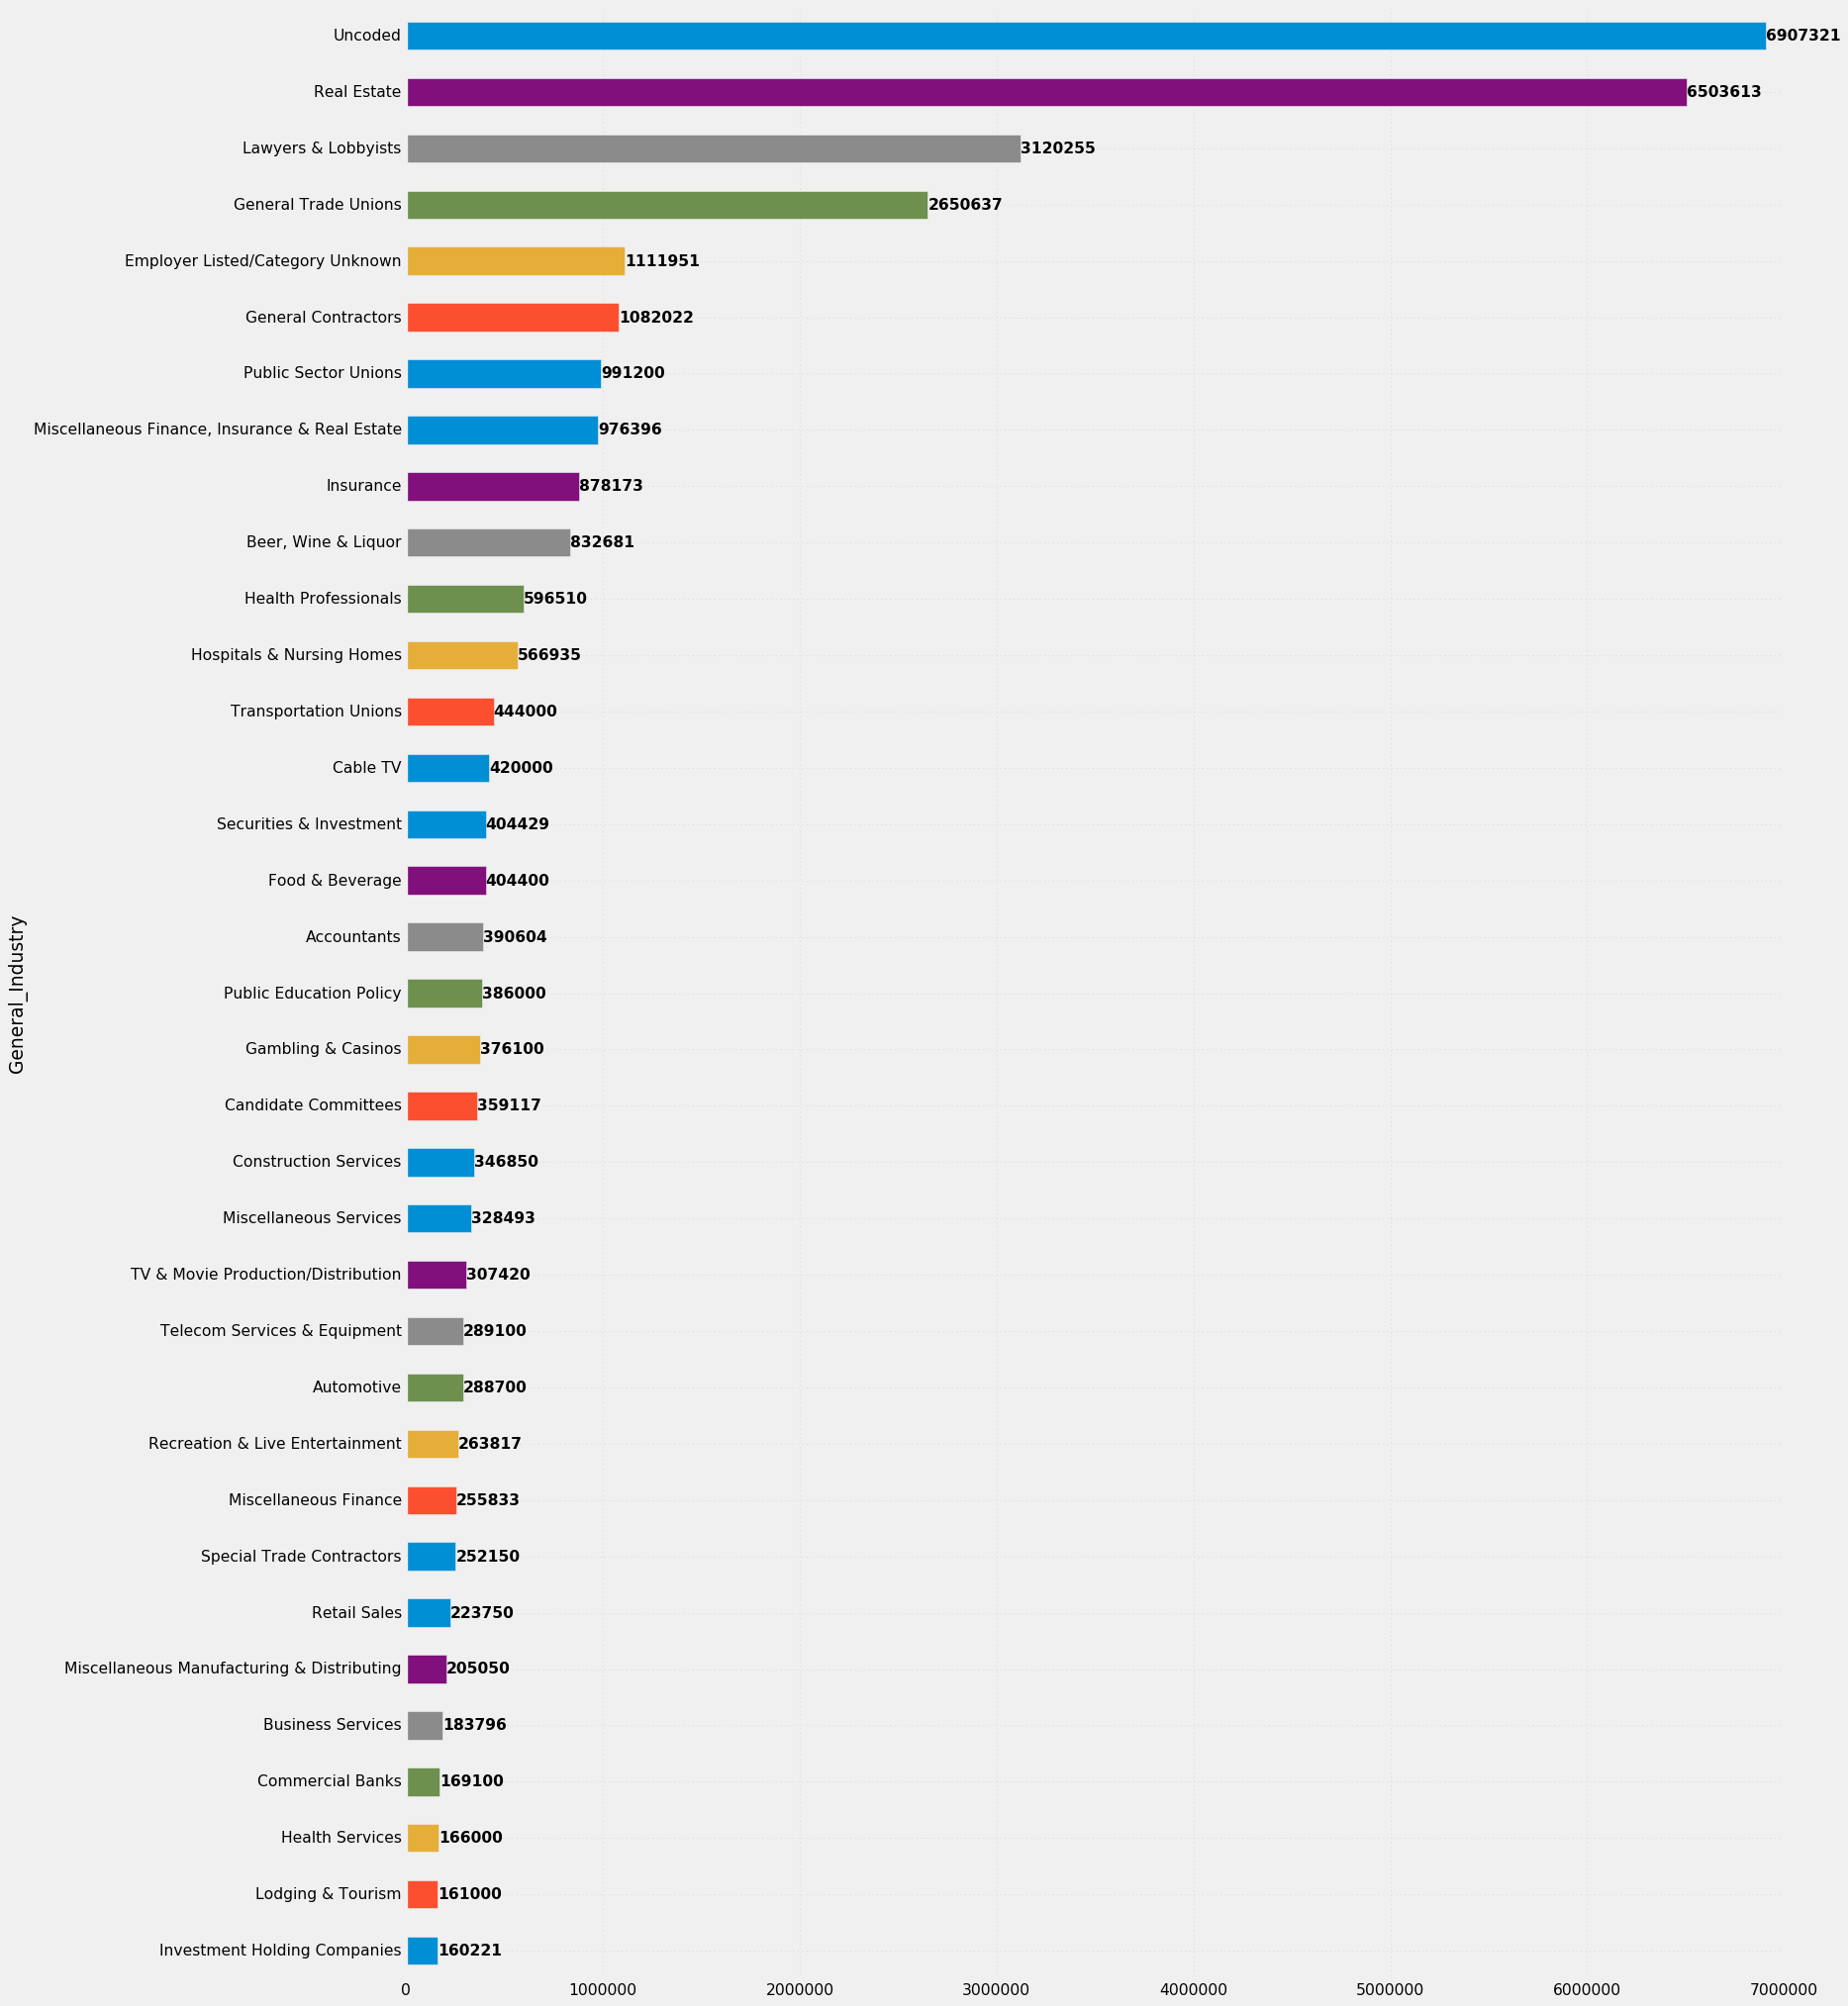

In [330]:
plt.figure(figsize=(20,30))
ax = df_warchest.groupby('General_Industry').filter(lambda x: x['Amount_boe'].sum() > 150000)\
.groupby('General_Industry')['Amount_boe']\
.sum().sort_values()\
.plot(y='Amount_boe', x='General_Industry', kind='barh')

for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')

plt.savefig("topindustries.pdf")

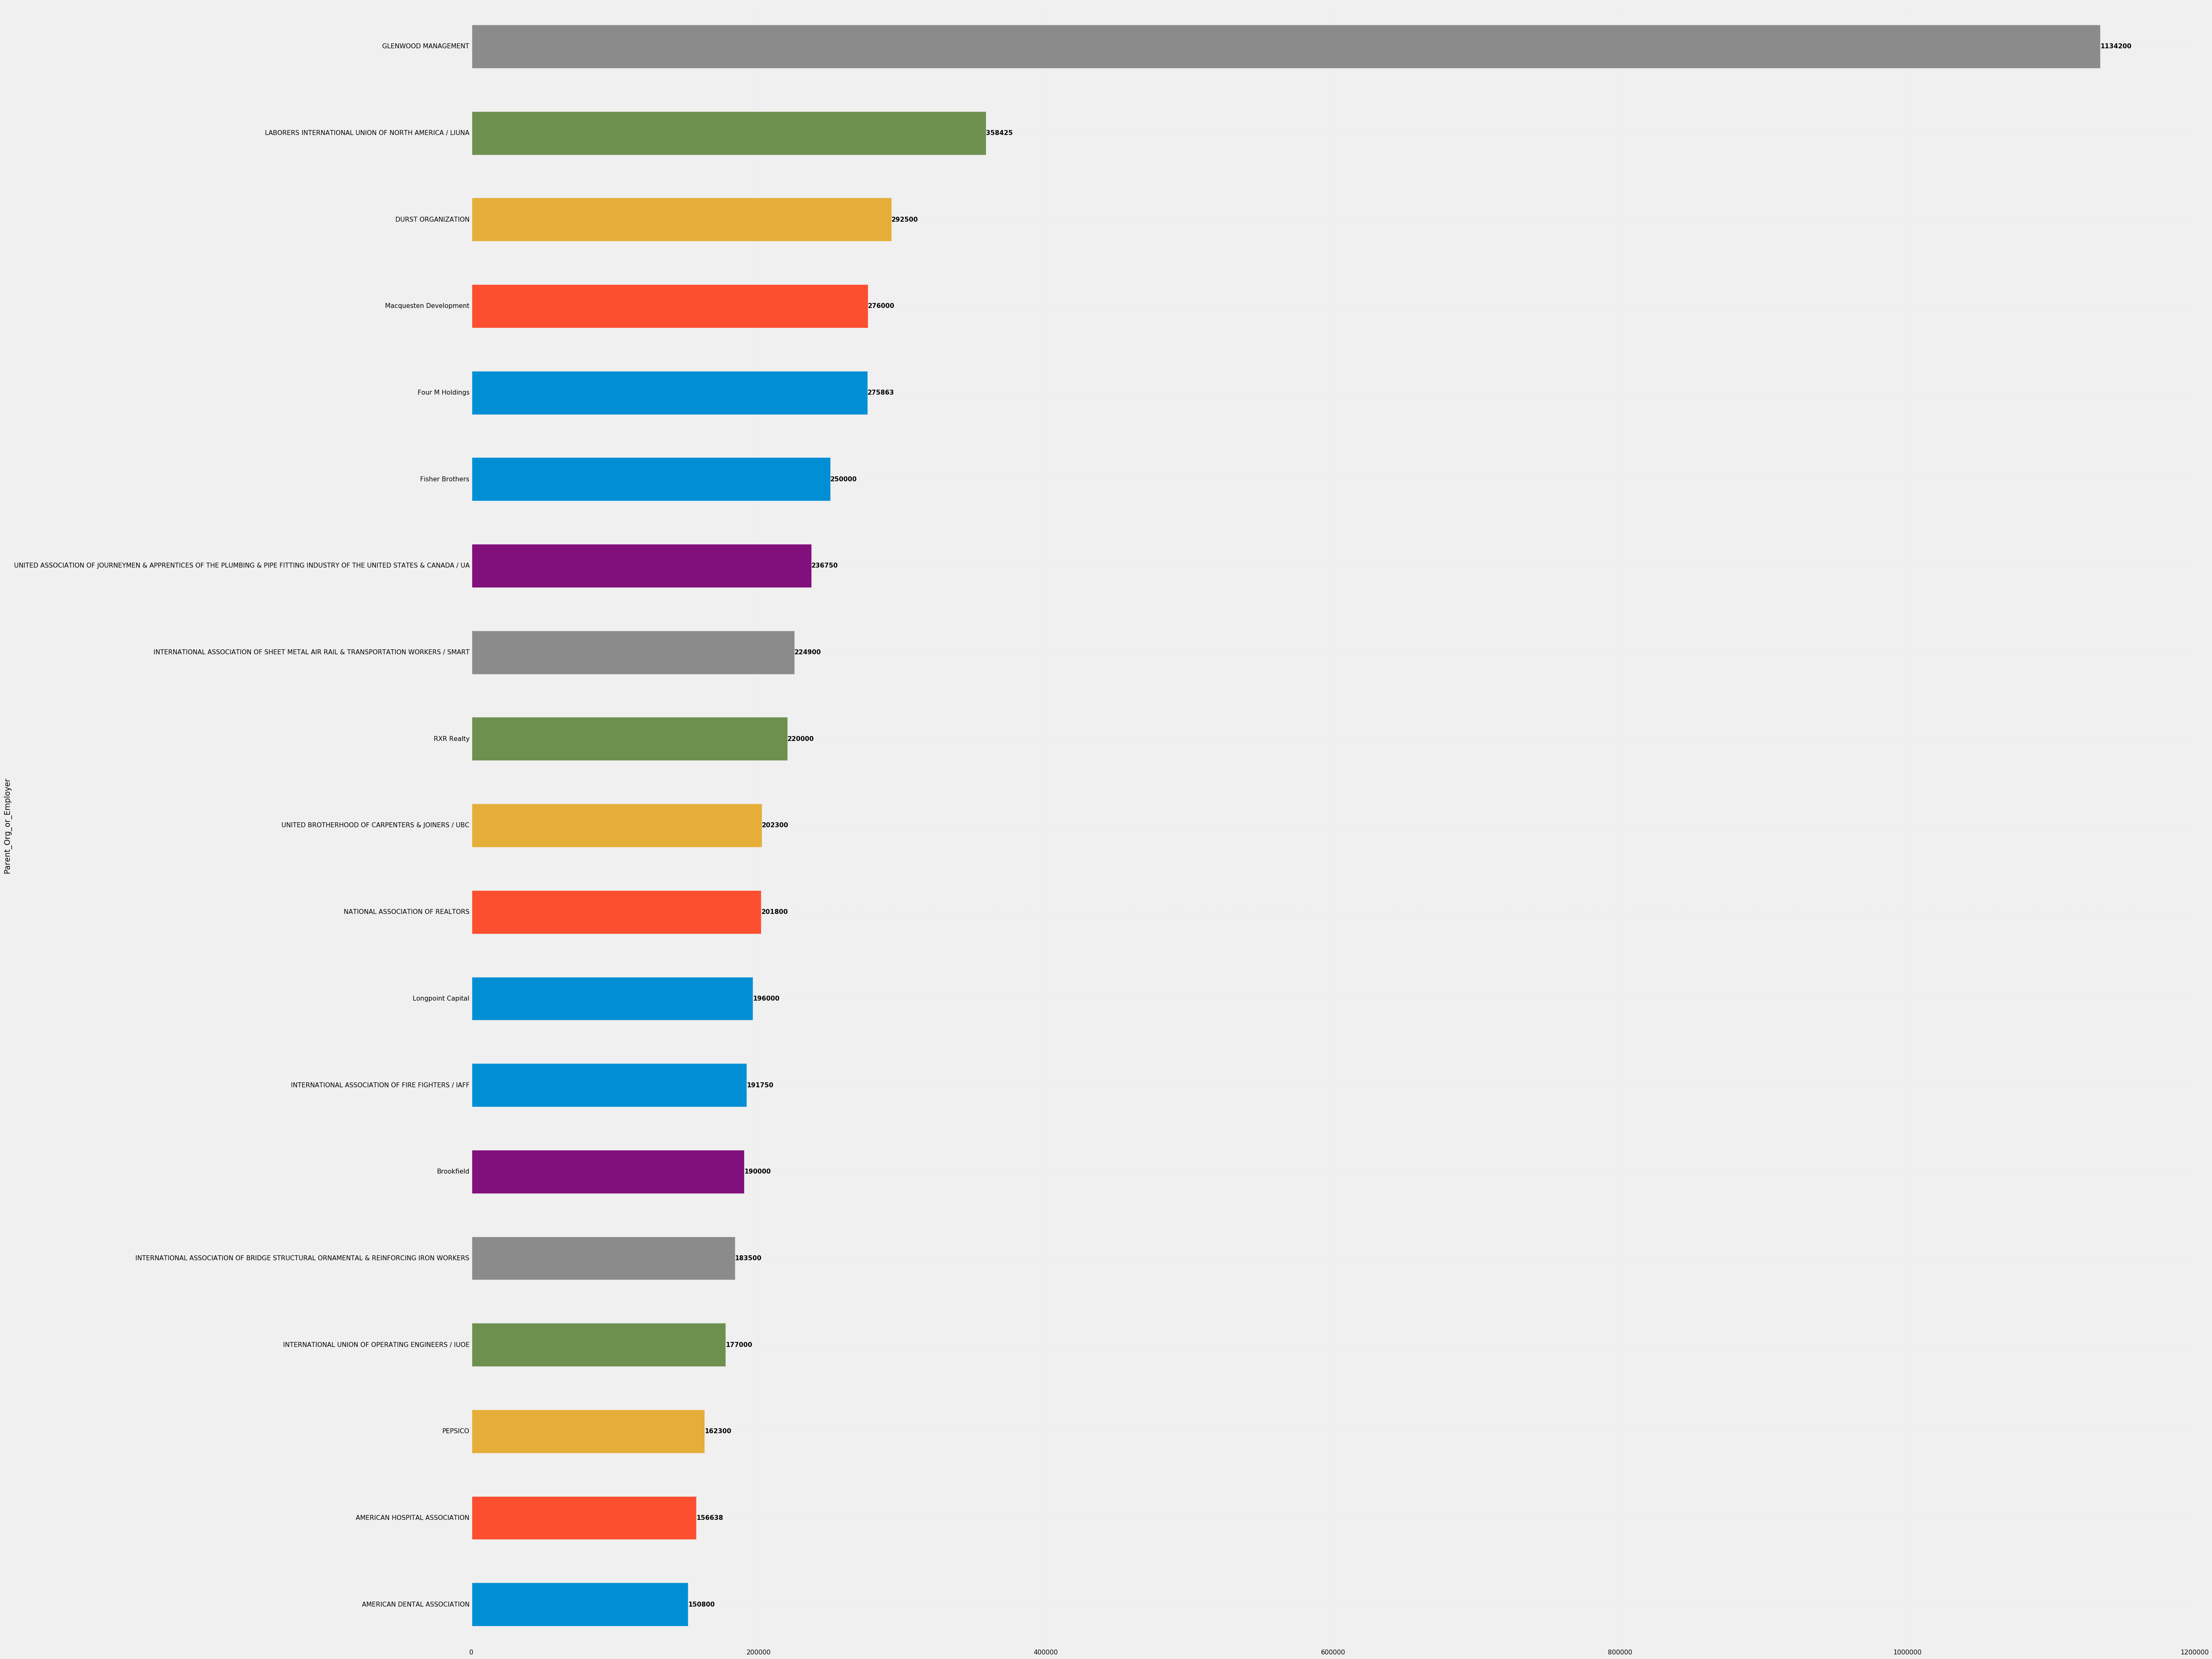

In [331]:
plt.figure(figsize=(60,60))
ax=df_warchest.groupby('Parent_Org_or_Employer').filter(lambda x: x['Amount_boe'].sum() > 150000)\
.groupby('Parent_Org_or_Employer')['Amount_boe']\
.sum().sort_values()\
.plot(y='Amount_boe', x='Parent_Org_or_Employer', kind='barh', )

for i, bar in enumerate(ax.patches):
    value = int(round(bar.get_width()))
    x_pos = bar.get_width() - 1
    y_pos = i
    ax.text(x_pos, y_pos, value, va='center', ha='left', color='black',fontweight='bold')
plt.savefig('topdonors.pdf')

## Nixon Peabody, LLP is an interesting case.

They've given a total of 51,326 to Cuomo-- but their average donation is $250. Their employees give to Cuomo all on the same day(s)

In [181]:
print("\nTotal from Nixon Peabody: ", df_warchest[df_warchest['Parent_Org_or_Employer']=='Nixon Peabody LLP']['Amount_boe'].sum())
print("Average from Nixon Peabody: " ,df_warchest[df_warchest['Parent_Org_or_Employer']=='Nixon Peabody LLP']['Amount_boe'].median())
print("\nDates Nixon Peabody gave to Cuomo:\n")

values = df_warchest[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604']['Date_boe'].value_counts().keys().tolist()
counts = df_warchest[df_warchest['Address']=='1300 CLINTON SQ ROCHESTER, NY, 14604']['Date_boe'].value_counts().tolist()

i=0

for value in values:
    print("On", value, "there were", counts[i], "donations.")
    i+=1


Total from Nixon Peabody:  51326.0
Average from Nixon Peabody:  250.0

Dates Nixon Peabody gave to Cuomo:

On 12/12/2016 there were 34 donations.
On 06/26/2017 there were 13 donations.
On 12/12/2017 there were 11 donations.
On 05/13/2015 there were 1 donations.
On 07/05/2016 there were 1 donations.


## The data from Follow the Money is rich, but incomplete:
With their data, I didn't have information on 85% of Cuomo's donors. Now it is a bit clearer.

In [182]:
count, _ = df_warchest.shape

print("Percent of 'Broad Sector' unknown:", str(round(df_warchest[(df_warchest['Broad_Sector']== 'Unknown') | (df_warchest['Broad_Sector']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")
print("Percent of 'General Industry' unknown:", str(round(df_warchest[(df_warchest['General_Industry']== 'Unknown') | (df_warchest['General_Industry']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")
print("Percent of 'Parent Org or Employer' unknown:", str(round(df_warchest[(df_warchest['Parent_Org_or_Employer']== 'Unknown') | (df_warchest['Parent_Org_or_Employer']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+ "%")
print("Percent of 'specific business' unknown:", str(round(df_warchest[(df_warchest['Specific_Business']== 'Unknown') | (df_warchest['Specific_Business']== 'Uncoded')]\
['Donor'].count()/count, 2)*100)+"%")

Percent of 'Broad Sector' unknown: 10.0%
Percent of 'General Industry' unknown: 9.0%
Percent of 'Parent Org or Employer' unknown: 0.0%
Percent of 'specific business' unknown: 9.0%


## LLC's

In [194]:
unknown_llc_number = df_warchest[(df_warchest['Donor'].str.contains('LLC'))|\
            (df_warchest['Broad_Sector']=='Unknown')|\
            (df_warchest['General_Industry']=='Unknown')|\
            (df_warchest['Specific_Business']=='Unknown')|\
            (df_warchest['Parent_Org_or_Employer']=='Unknown')]\
            ['Donor'].nunique()
print(df_warchest[df_warchest['Donor'].str.contains("LLC", na=False)]['Donor'].nunique())

1254


## I'm going to cross-reference the list of Cuomo donor LLCs with a nyc-db to see if there are any matches.

In [195]:
llc_list = df_warchest[(df_warchest['Donor'].str.contains('LLC')) |\
            (df_warchest['Broad_Sector']=='Unknown')|\
            (df_warchest['General_Industry']=='Unknown')|\
            (df_warchest['Specific_Business']=='Unknown')|\
            (df_warchest['Parent_Org_or_Employer']=='Unknown')]

#Here I checked the LLC names against the LLCs listed in DOBJOBS

llc_list.columns = [c.lower() for c in llc_list.columns] #postgres doesn't like capitals or spaces

from sqlalchemy import create_engine
engine = create_engine('postgresql://GeorgiaKromrei@localhost:5432/housing_data_analysis')

llc_list.to_sql("cuomo_llc_list", engine, if_exists="replace")
print("I'm loading", llc_list['donor'].nunique(), "unique LLC names into nyc-db for cross-referencing.")

I'm loading 1254 unique LLC names into nyc-db for cross-referencing.


## So I can answer the question: how many landlords used their shell LLC's for managing buildings, and also for donating to Cuomo?

I start by running the cuomo_llc_list.csv file through nyc-db's dobjobs table, to find exact matches-- this will be a "minimum" number. I find 132 unique LLCs that are both Cuomo donors and landlord LLCs.

In [196]:
#These are the LLC's I get by matching directly in SQL.

df_llc=pd.read_csv('cuomo_llc_list.csv')
df_llc['ownersphone']=df_llc['ownersphone'].astype(str)
df_llc['ownersbusinessname'].nunique()

132

## But for a more exhaustive list, I'm going to need a list of all the LLC's in New York City.

That looks like about 175,000 unique LLCs. I'm going to match them up to the Cuomo LLC's.
I run the following query on my local copy of nyc-db to get all of the LLC's from DOBJOBS in New York:

```CREATE TABLE nyc_llc AS SELECT ownersbusinessname, bbl, address FROM dobjobs WHERE ownersbusinessname LIKE('%LLC%') GROUP BY ownersbusinessname, bbl, address                                                                 ;
SELECT 175564
```

In [197]:
#If I use Python, I get a few more

nyc_llc = pd.read_csv('nyc_llc.csv')
nyc_llc['businessname_nollc'] = nyc_llc['ownersbusinessname'].str.upper().str.replace(r',? LLC.*','')
llc_list['donorname_nollc'] = llc_list['donor'].str.replace(r',? LLC.*','')

unique = llc_list[llc_list['donorname_nollc'].isin(nyc_llc['businessname_nollc'])]['donor'].nunique()

print("There are", unique, '''unique LLC's in NYC-DB who have given to Cuomo's campaign that were unidentified by\
either Follow the Money or the Board of Elections.''')

There are 168 unique LLC's in NYC-DB who have given to Cuomo's campaign that were unidentified byeither Follow the Money or the Board of Elections.


## I want more granular information on each LLC, how much they've given to Cuomo and when. 

So I won't just check to see if they match to some LLC in Cuomo's donor list: but confirm exactly which one(s) they match.

In [198]:
llc_list = llc_list.merge(nyc_llc, right_on='businessname_nollc', left_on='donorname_nollc', how='left')
llc_list.drop_duplicates('check no.', keep='first', inplace=True)
llc_list.ownername = llc_list.ownername.str.upper().str.replace("ESPOISTO", "ESPOSITO")\
                                        .str.replace("EDWARD KAMIN", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKI", "EDWARD KAMINSKY")\
                                        .str.replace("TIVADAR MARCOVICI", "TIVADAR MARCOVICCI")\
                                        .str.replace("EDWARD KAMINSKYSKI", "EDWARD KAMINSKY")\
                                        .str.replace("EDWARD KAMINSKYSKY", "EDWARD KAMINSKY")\
                                        .str.replace("JOHNATHAN", "JONATHAN")\
                                        .str.replace("PETRACCA LESTER", "LESTER PETRACCA")\
                                        .str.replace("LOIS ESPOSITO", "LOUIS ESPOSITO")\
                                        .str.replace("LEONARD LITWIM", "LEONARD LITWIN")
                        


dumb_landlords = llc_list.groupby(['ownername'], as_index=False)\
    .agg(lambda x : x.sum() if x.dtype=='float64' else list(set(x)))

In [199]:
dumb_landlords.rename(columns={'ownername': 'dobjobs_ownername',
                               'address_x': 'cuomo_donor_address',
                               'address_y': 'dobjobs_address',
                                  'amount': 'donation_total',
                      'ownersbusinessname': 'dobjobs_ownersbusinessname',
                             'ownersphone': 'dobjobs_ownersphone'}, inplace=True)

## Landlords who use shell LLC's to hide from their tenants, and also to donate to Cuomo. Let's see who uses the most different LLC's:

In [237]:
pd.set_option('display.max_rows', None)
s = dumb_landlords.donor.str.len().sort_values(ascending=False).index
dumb_landlords.reindex(s)

,dobjobs_ownername,donor,cuomo_donor_address,check no.,amount_boe,date_boe,recipient,transaction code,contribution code,fiscal report,...,city,state,zip,in-state,parent_org_or_employer,donorname_nollc,dobjobs_ownersbusinessname,dobjobs_address,dobjobs_ownersphone,businessname_nollc
47,JONATHAN RESNICK,"[315 HUDSON LLC, 250 HUDSON STREET LLC, RESNICK SEAPORT LLC, 133 E 58TH STREET LLC, 161 WILLIAM STREET LLC, AB 40TH STREET LLC, RESNICK 255 GREENWICH LLC, RB 52 CO. LLC]","[110 E 59TH ST NEW YORK, NY, 10022]","[chk 22154, chk 5172, chk 19006, chk 18559, chk 20957, chk 13968, chk 12179, chk 29158]",20000.0,[11/16/2017],[ANDREW CUOMO 2018 INC.],[Monetary Contributions/All Other],[nan],[Periodic Jan.],...,"[NEW YORK, nan]","[nan, NY]",70154.0,7.0,[nan],"[133 E 58TH STREET, 161 WILLIAM STREET, 315 HUDSON, RESNICK SEAPORT, RB 52 CO., AB 40TH STREET, RESNICK 255 GREENWICH, 250 HUDSON STREET]","[315 HUDSON LLC, 250 HUDSON STREET LLC, RESNICK SEAPORT LLC, 133 E 58TH STREET LLC, 161 WILLIAM STREET LLC, AB 40TH STREET LLC, RESNICK 255 GREENWICH LLC, RB 52 CO. LLC]","[315 HUDSON ST, 10022, 161 WILLIAM STREET, 10022, 199 WATER ST, 10022, 133 E 58 STREET, 10022, 255 GREENWICH STREET, 10022, 215 SEVENTH AVENUE, 10022, 250 HUDSON STREET, 10022, 52 BROADWAY, 10002]",[2124211300],"[133 E 58TH STREET, 161 WILLIAM STREET, 315 HUDSON, RESNICK SEAPORT, RB 52 CO., AB 40TH STREET, RESNICK 255 GREENWICH, 250 HUDSON STREET]"
22,EDWARD KAMINSKY,"[GRAND ASSOCIATES, LLC, BRADY ASSOCIATES, LLC, ADEE REALTY, LLC, ROLIL REALTY, LLC, HILLCREST REALTY CO., LLC, FIEBER REALTY, LLC, GERLAN REALTY, LLC]","[105 COURT STREET BROOKLYN, NY, 11201]","[15081, 16040, 15003, 11859, 14524, 15079, 11832, 16946]",13500.0,"[11/25/2013, 08/30/2013]",[ANDREW CUOMO 2018 INC.],[Monetary Contributions/All Other],[nan],[Periodic Jan.],...,[nan],[nan],0.0,0.0,[nan],"[GERLAN REALTY, FIEBER REALTY, ADEE REALTY, BRADY ASSOCIATES, GRAND ASSOCIATES, HILLCREST REALTY CO., ROLIL REALTY]","[ROLIL REALTY LLC, FIEBER REALTY LLC, HILLCREST REALTY CO. LLC, BRADY ASSOCIATES LLC C/O FIEBER, GERLAN REALTY LLC, ADEE REALTY LLC, GRAND ASSOCIATES LLC]","[2157 HOLLAND AVENUE, 11201, 275 W 238 ST, 11201, 2070 BRONX PARK EAST, 11201, 315 GRAND STREET, 11201, 808 ADEE AVE, 10467, 224 WEST 4TH STREET, 11201, 2508 TRATMAN AVENUE, 11201]","[7188524001, 2127503636, 7188524000]","[GERLAN REALTY, FIEBER REALTY, ADEE REALTY, BRADY ASSOCIATES, GRAND ASSOCIATES, HILLCREST REALTY CO., ROLIL REALTY]"
60,LOUIS ESPOSITO,"[DOLP 733 PROPERTIES LLC, DOLP 1155 PROPERTIES LLC, DOLP 1133 PROPERTIES LLC, DOLP 675 PROPERTIES LLC, DOLP 205 PROPERTIES LLC, DOLP 114 PROPERTIES LLC]","[1155 AVENUE OF THE AMERICAS, 9TH FLOOR NEW YORK, NY, 10036, 1155 AVENUE OF THE AMERICAS NEW YORK, NY, 10036, FL 9, 1155 AVENUE OF THE AMERICAS NEW YORK, NY, 10036, 1 BRYANT PARK NEW YORK, NY, 10036, 1155 AVE OF THE AMERICAS NEW YORK, NY, 10036, FL 9 1155 AVENUE OF THE AMERICAS NEW YORK, NY, 10036, FL 49, 1 BRYANT PARK NEW YORK, NY, 10036]","[10326, 05043, 3086, 11120, 8088, chk 3501, 4117, chk 2, 7096, 8114, 7117, chk 000006, chk 1, 03104, 4207, 4118, 11100, 10306, 7095, chk 10393]",212500.0,"[07/11/2016, 03/09/2011, 10/05/2015, 07/11/2012, 08/06/2013, 06/28/2013, 11/06/2017]",[ANDREW CUOMO 2018 INC.],[Monetary Contributions/All Other],[nan],"[Periodic July, Periodic Jan.]",...,[NEW YORK],[NY],200720.0,20.0,"[nan, DURST ORGANIZATION]","[DOLP 205 PROPERTIES, DOLP 1133 PROPERTIES, DOLP 733 PROPERTIES, DOLP 114 PROPERTIES, DOLP 1155 PROPERTIES, DOLP 675 PROPERTIES]","[DOLP 733 PROPERTIES LLC, DOLP 1155 PROPERTIES LLC, DOLP 1133 PROPERTIES LLC, DOLP 675 PROPERTIES LLC, DOLP 205 PROPERTIES LLC, DOLP 114 PROPERTIES LLC]","[733 3 AVENUE, 10036, 201 EAST 42 STREET, 10036, 114 WEST 47 STREET, 10036, 205 EAST 42 STREET, 10036, 110 WEST 44 STREET, 10036, 1155 6 AVENUE, 10036]",[2127891155],"[DOLP 205 PROPERTIES, DOLP 1133 PROPERTIES, DOLP 733 PROPERTIES, DOLP 114 PROPERTIES, DOLP 1155 PROPERTIES, DOLP 675 PROPERTIES]"
94,SHERI SHULMAN,"[203 WEST 90TH STREET 

*Edward Kaminsky*
- a luxury real estate agent. Is he related to senator Todd Kaminsky?

*Jonathan Resnick*
- member of REBNY, who used 7 different LLC's to contribute to Cuomo
- for a total of $20,000$ all on the same day: November 16, 2017.
- The LLC's were all totally different, but registered to the same address. The donations were for $2,500 each.

*Louis Esposito* used 5 different LLC's to donate 212,500 to Cuomo.
- He is a lobbyist with Durst, according to Little Sis: https://littlesis.org/org/68088-Durst_Organization_Inc
- Durst is a member of REBNY.

*Leonard Litwin* (deceased) and *Charles Dorego* are both executives at *Glenwood Management*, Cuomo's biggest single donor. All together they've donated more than 1/2 million to Cuomo.

*Jorge Madruga*
-ceo of MADDD Equities and has also given to Marco Rubio

*Exact Capital*
-50,000 to Cuomo on January 9. Politico reported, Real Deal summarized: https://therealdeal.com/2017/01/23/cuomo-raises-4-4m-with-help-of-real-estate-donors/

*Sabah Rajput*
- Walison Corporation
- Affordable Housing Developer, https://commercialobserver.com/2017/03/sterling-lends-16m-on-bronx-affordable-housing-development-15-more-projects-on-the-way/


In [ ]:
#Scott Alper, CEO of Witkoff Group, gave 50,000 in 2017

IFrame("https://littlesis.org/maps/2861-cuomo-rebny-map/embedded/v2", width=700, height=600)

In [236]:
dumb_landlords.sort_values('amount_boe', ascending=False)

,dobjobs_ownername,donor,cuomo_donor_address,check no.,amount_boe,date_boe,recipient,transaction code,contribution code,fiscal report,...,city,state,zip,in-state,parent_org_or_employer,donorname_nollc,dobjobs_ownersbusinessname,dobjobs_address,dobjobs_ownersphone,businessname_nollc
60,LOUIS ESPOSITO,"[DOLP 733 PROPERTIES LLC, DOLP 1155 PROPERTIES LLC, DOLP 1133 PROPERTIES LLC, DOLP 675 PROPERTIES LLC, DOLP 205 PROPERTIES LLC, DOLP 114 PROPERTIES LLC]","[1155 AVENUE OF THE AMERICAS, 9TH FLOOR NEW YORK, NY, 10036, 1155 AVENUE OF THE AMERICAS NEW YORK, NY, 10036, FL 9, 1155 AVENUE OF THE AMERICAS NEW YORK, NY, 10036, 1 BRYANT PARK NEW YORK, NY, 10036, 1155 AVE OF THE AMERICAS NEW YORK, NY, 10036, FL 9 1155 AVENUE OF THE AMERICAS NEW YORK, NY, 10036, FL 49, 1 BRYANT PARK NEW YORK, NY, 10036]","[10326, 05043, 3086, 11120, 8088, chk 3501, 4117, chk 2, 7096, 8114, 7117, chk 000006, chk 1, 03104, 4207, 4118, 11100, 10306, 7095, chk 10393]",212500.0,"[07/11/2016, 03/09/2011, 10/05/2015, 07/11/2012, 08/06/2013, 06/28/2013, 11/06/2017]",[ANDREW CUOMO 2018 INC.],[Monetary Contributions/All Other],[nan],"[Periodic July, Periodic Jan.]",...,[NEW YORK],[NY],200720.0,20.0,"[nan, DURST ORGANIZATION]","[DOLP 205 PROPERTIES, DOLP 1133 PROPERTIES, DOLP 733 PROPERTIES, DOLP 114 PROPERTIES, DOLP 1155 PROPERTIES, DOLP 675 PROPERTIES]","[DOLP 733 PROPERTIES LLC, DOLP 1155 PROPERTIES LLC, DOLP 1133 PROPERTIES LLC, DOLP 675 PROPERTIES LLC, DOLP 205 PROPERTIES LLC, DOLP 114 PROPERTIES LLC]","[733 3 AVENUE, 10036, 201 EAST 42 STREET, 10036, 114 WEST 47 STREET, 10036, 205 EAST 42 STREET, 10036, 110 WEST 44 STREET, 10036, 1155 6 AVENUE, 10036]",[2127891155],"[DOLP 205 PROPERTIES, DOLP 1133 PROPERTIES, DOLP 733 PROPERTIES, DOLP 114 PROPERTIES, DOLP 1155 PROPERTIES, DOLP 675 PROPERTIES]"
10,CHARLES DOREGO,"[92ND REALTY LLC, ARWIN 74TH STREET LLC, EAST 72ND REALTY LLC, EAST 81ST REALTY, LLC]","[1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040, 1200 UNION TPKE NEW HYDE PARK, NY, 11040]","[1068, 1066, 20040, 1053, 20022, 20001]",127000.0,"[01/07/2014, 07/14/2014, 01/11/2010, 01/08/2013]",[ANDREW CUOMO 2018 INC.],[Monetary Contributions/All Other],[nan],"[Periodic July, Periodic Jan.]",...,"[nan, NEW HYDE PARK]","[nan, NY]",55200.0,5.0,[GLENWOOD MANAGEMENT],"[92ND REALTY, EAST 81ST REALTY, EAST 72ND REALTY, ARWIN 74TH STREET]","[EAST 81ST REALTY LLC, 92ND REALTY LLC, ARWIN 74TH STREET LLC, EAST 72ND REALTY LLC]","[1430 SECOND AVENUE, 11040, 1365 YORK AVENUE, 11040, 1195 LEXINGTON AVENUE, 11040, 1775 YORK AVENUE, 11040]","[7183436400, 5167391616]","[92ND REALTY, EAST 81ST REALTY, EAST 72ND REALTY, ARWIN 74TH STREET]"
88,ROBERT SMITH,"[EAST 85TH REALTY LLC, EAST 77TH REALTY LLC]","[1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040, 1200 UNION TPKE NEW HYDE PARK, NY, 11040]","[1110, 20019, 20007, 20029, 1037]",125000.0,"[06/30/2011, 01/08/2013, 10/31/2011, 05/16/2012, 01/07/2014]",[ANDREW CUOMO 2018 INC.],[Monetary Contributions/All Other],[nan],"[Periodic July, Periodic Jan.]",...,[NEW HYDE PARK],[NY],55200.0,5.0,[GLENWOOD MANAGEMENT],"[EAST 77TH REALTY, EAST 85TH REALTY]","[EAST 85TH REALTY LLC, EAST 77TH REALTY LLC]","[500 EAST 85TH STREET, 11040, 500 EAST 77TH STREET, 11040]",[7183430909],"[EAST 77TH REALTY, EAST 85TH REALTY]"
58,LEONARD LITWIN,"[TRIBECA NORTH END LLC, BARCLAY STREET REALTY LLC, LIBERTY STREET REALTY LLC, EAST 103RD STREET REALTY LLC]","[1200 UNION TURNPIKE NEW HYDE PARK, NY, 11040, 327-347 103RD STREET NEW YORK, NY, 10029, 1200 UNION TURNPIKE NEW HYDE, NY, 11040]","[20000, 20025, 1363, 20017, 20013, 20028, 20034]",120000.0,"[01/11/2010, 01/08/2013, 06/30/2011, 05/16/2012, 07/11/2014]",[ANDREW CUOMO 2018 INC.],[Monetary Contributions/All Other],[nan],"[Periodic July, Periodic Jan.]",...,"[NEW YORK, NEW HYDE PARK]",[NY],76269.0,7.0,[GLENWOOD MANAGEMENT],"[EAST 103RD STREET REALTY, BARCLAY STREET REALTY, LIBERTY STREET REALTY, TRIBECA NORTH END]","[Tribeca North End LLC, BARCLAY STREET REALTY LLC, LIBERTY STREET REALTY LLC, EAST 103RD STREET REALTY LLC]",

## Some summary statistics and information on Cuomo's LLC's.

- What percent of donations count are they?
- What percent of the total donations dollar amount are they?
- Do they give more or less than Cuomo's average donor?

In [ ]:
rows, _ = df_warchest[df_warchest['Donor'].str.contains("LLC",na=False)].shape
total_rows, _ = df_warchest.shape
print(rows, "or", round(rows/total_rows * 100, 2), "% of donations are from LLCs.")
df_llc = df_warchest[df_warchest['Donor'].str.contains("LLC",na=False)]
df_not_llc = df_warchest[~df_warchest['Donor'].str.contains("LLC",na=False)]
print("The total given by LLCs is:", '${:,.2f}'.format(df_llc['Amount_boe'].sum()))
print("Which is", round(df_llc['Amount_boe'].sum()/df_warchest['Amount_boe'].sum()*100, 2), "% of the total dollar amount.")
unique, _ = df_llc.groupby("Address").first().shape
print("There are", unique, "unique LLCs in the past 8 years of campaign contributions.")
avg_donation = df_not_llc['Amount_boe'].median()
llc_av_donation = df_llc['Amount_boe'].median()
print("Cuomo's donors give an average of", '${:,.2f}'.format(avg_donation), "while LLCs give an average of", '${:,.2f}'.format(llc_av_donation))